Cell 0 — Setup & paths

In [1]:
# Ensure repo root is CWD and src is importable
import os, sys, pathlib
if pathlib.Path.cwd().name == "notebooks":
    os.chdir("..")
ROOT = pathlib.Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
print("CWD:", ROOT)

CWD: /Users/abhistaatchutuni/Desktop/freshretail-demand-forecasting


Cell 1 — Load latest sample

In [2]:
import pandas as pd
from src.config import INTERIM_DIR

p = max(pathlib.Path(INTERIM_DIR).glob("train_sample_*.parquet"), key=lambda x: x.stat().st_mtime)
df = pd.read_parquet(p, engine="pyarrow")
df["dt"] = pd.to_datetime(df["dt"])
df = df.sort_values("dt").reset_index(drop=True)
print("Loaded:", df.shape, "| dates:", df["dt"].min().date(), "→", df["dt"].max().date())
df.head()

Loaded: (200000, 19) | dates: 2024-03-28 → 2024-06-25


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,stock_hour6_22_cnt,hours_stock_status,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
0,0,172,6,8,29,116,853,2024-03-28,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000,0,0,1.6998,15.54,73.67,2.20
1,15,510,2,29,78,82,4,2024-03-28,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",15,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...",0.882,0,1,4.1835,18.50,80.34,2.36
2,16,549,0,28,3,7,381,2024-03-28,1.1,"[0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, ...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000,0,0,1.7489,16.75,75.87,1.56
3,12,418,6,20,50,183,822,2024-03-28,0.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.986,0,0,4.6216,17.90,78.67,2.07
4,12,364,1,7,17,49,266,2024-03-28,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000,0,0,4.6325,18.25,78.71,2.20


Cell 2 — Feature builders: time + stock/hour summaries

In [3]:
import numpy as np
import pandas as pd

def add_time_features(d):
    d = d.copy()
    d["dayofweek"] = d["dt"].dt.dayofweek
    d["is_weekend"] = d["dayofweek"].isin([5,6]).astype(int)
    d["month"] = d["dt"].dt.month
    return d

def _is_listlike(v):
    return isinstance(v, (list, tuple, np.ndarray))

def add_stock_and_hour_features(d):
    d = d.copy()
    # hours_sale -> summary stats
    d["hours_sale_len"]  = d["hours_sale"].apply(lambda x: len(x) if _is_listlike(x) else np.nan)
    d["hours_sale_sum"]  = d["hours_sale"].apply(lambda x: float(np.nansum(x)) if _is_listlike(x) else np.nan)
    d["hours_sale_mean"] = d["hours_sale"].apply(lambda x: float(np.nanmean(x)) if _is_listlike(x) else np.nan)
    d["hours_sale_max"]  = d["hours_sale"].apply(lambda x: float(np.nanmax(x)) if _is_listlike(x) else np.nan)

    # hours_stock_status -> fraction of hours in stock (treat >0 as "in stock")
    def frac_instock(arr):
        if not _is_listlike(arr) or len(arr) == 0:
            return np.nan
        a = np.array(arr, dtype=float)
        return float((a > 0).mean())
    d["instock_frac"] = d["hours_stock_status"].apply(frac_instock)
    return d

df_feat = add_time_features(df)
df_feat = add_stock_and_hour_features(df_feat)
df_feat.head()

,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,...,avg_humidity,avg_wind_level,dayofweek,is_weekend,month,hours_sale_len,hours_sale_sum,hours_sale_mean,hours_sale_max,instock_frac
0,0,172,6,8,29,116,853,2024-03-28,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ...",...,73.67,2.20,3,0,3,24,0.2,0.008333,0.1,0.000000
1,15,510,2,29,78,82,4,2024-03-28,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,80.34,2.36,3,0,3,24,1.0,0.041667,0.9,0.958333
2,16,549,0,28,3,7,381,2024-03-28,1.1,"[0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, ...",...,75.87,1.56,3,0,3,24,1.1,0.045833,0.3,0.208333
3,12,418,6,20,50,183,822,2024-03-28,0.7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, ...",...,78.67,2.07,3,0,3,24,0.7,0.029167,0.2,0.000000
4,12,364,1,7,17,49,266,2024-03-28,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,78.71,2.20,3,0,3,24,0.2,0.008333,0.2,0.000000


Cell 3 — Lags & rolling windows

In [4]:
def add_lag_rolling(d, group_cols=("store_id","product_id"), target="sale_amount"):
    d = d.sort_values(["dt"]).copy()
    g = d.groupby(list(group_cols), group_keys=False)

    d["lag_1"]  = g[target].shift(1)
    d["lag_7"]  = g[target].shift(7)
    d["roll_7_mean"]  = g[target].rolling(7, min_periods=1).mean().reset_index(level=list(range(len(group_cols))), drop=True)
    d["roll_30_mean"] = g[target].rolling(30, min_periods=1).mean().reset_index(level=list(range(len(group_cols))), drop=True)
    return d

df_feat = add_lag_rolling(df_feat)
needed = ["lag_1","lag_7","roll_7_mean","roll_30_mean"]
print("NA rows after lags:", int(df_feat[needed].isna().any(axis=1).sum()))
df_feat.head()

NA rows after lags: 196304


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,hours_sale,...,month,hours_sale_len,hours_sale_sum,hours_sale_mean,hours_sale_max,instock_frac,lag_1,lag_7,roll_7_mean,roll_30_mean
0,0,172,6,8,29,116,853,2024-03-28,0.2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, ...",...,3,24,0.2,0.008333,0.1,0.000000,NaN,NaN,0.2,0.2
1524,0,678,3,14,40,146,793,2024-03-28,0.5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,3,24,0.5,0.020833,0.1,0.041667,NaN,NaN,0.5,0.5
1523,11,533,5,16,27,97,250,2024-03-28,0.5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, ...",...,3,24,0.5,0.020833,0.2,0.750000,NaN,NaN,0.5,0.5
1522,13,646,3,25,71,213,447,2024-03-28,1.8,"[0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, ...",...,3,24,1.8,0.075000,0.5,0.125000,NaN,NaN,1.8,1.8
1521,0,713,6,10,38,190,715,2024-03-28,0.4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, ...",...,3,24,0.4,0.016667,0.1,0.000000,NaN,NaN,0.4,0.4


Cell 4 — Split (last 30 days) & define features

In [55]:
# Drop rows where lags are NA
df_model = df_feat.dropna(subset=["lag_1","lag_7","roll_7_mean","roll_30_mean"]).copy()

cutoff_date = df_model["dt"].max() - pd.Timedelta(days=30)
train = df_model[df_model["dt"] < cutoff_date]
valid = df_model[df_model["dt"] >= cutoff_date]

print(
    "Train:", train["dt"].min().date(), "→", train["dt"].max().date(), "| rows:", len(train),
    "\nValid:", valid["dt"].min().date(), "→", valid["dt"].max().date(), "| rows:", len(valid)
)

FEATURES = [
    "dayofweek","is_weekend","month",
    "lag_1","lag_7","roll_7_mean","roll_30_mean",
    "discount","holiday_flag","activity_flag",
    "precpt","avg_temperature","avg_humidity","avg_wind_level",
    "instock_frac","hours_sale_mean","hours_sale_max"
]
TARGET = "sale_amount"

X_train, y_train = train[FEATURES], train[TARGET]
X_valid, y_valid = valid[FEATURES], valid[TARGET]
X_train.shape, X_valid.shape

Train: 2024-04-18 → 2024-05-25 | rows: 292 
Valid: 2024-05-26 → 2024-06-25 | rows: 3404


((292, 17), (3404, 17))

Cell 5 — Metrics (safe)

In [56]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mape_safe(y_true, y_pred, eps=1e-3):
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_pred - y_true)/denom)))

def smape(y_true, y_pred, eps=1e-6):
    y_true = np.asarray(y_true, dtype=float); y_pred = np.asarray(y_pred, dtype=float)
    return float(100.0 * np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_true)+np.abs(y_pred)+eps)))

Cell 6 — HistGradientBoosting (train + predict)

In [57]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(max_depth=6, learning_rate=0.1, max_iter=300)
hgb.fit(X_train, y_train)
preds_hgb = hgb.predict(X_valid)

print("HistGB → RMSE:", rmse(y_valid, preds_hgb), "| MAPE:", mape_safe(y_valid, preds_hgb), "| SMAPE:", smape(y_valid, preds_hgb))

HistGB → RMSE: 1.0491371464249883 | MAPE: 7.227128012282465 | SMAPE: 27.302175530688206


Cell 7 — XGBoost (optional, with graceful fallback)

In [58]:
use_xgb = True
try:
    import xgboost as xgb
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_valid, label=y_valid)
    params = {
        "objective":"reg:squarederror",
        "eval_metric":"rmse",
        "max_depth":8,
        "eta":0.1,
        "subsample":0.8,
        "colsample_bytree":0.8
    }
    xgb_model = xgb.train(params, dtrain, num_boost_round=400, evals=[(dvalid,"valid")], early_stopping_rounds=30, verbose_eval=False)
    preds_xgb = xgb_model.predict(dvalid)
    print("XGBoost → RMSE:", rmse(y_valid, preds_xgb), "| MAPE:", mape_safe(y_valid, preds_xgb), "| SMAPE:", smape(y_valid, preds_xgb))
except Exception as e:
    use_xgb = False
    print("XGBoost unavailable or failed:", e)

XGBoost → RMSE: 0.6695977715073317 | MAPE: 0.37694465482550865 | SMAPE: 11.29678383646089


Cell 8 — Plot (aggregate daily, best model)

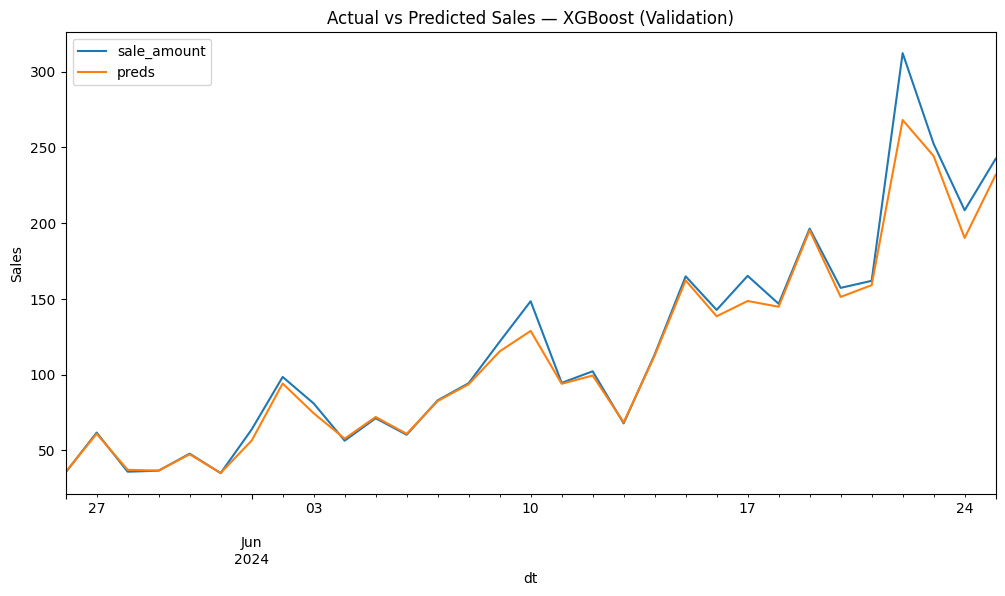

In [59]:
import matplotlib.pyplot as plt

best_name, best_preds = ("XGBoost", preds_xgb) if use_xgb else ("HistGB", preds_hgb)
sample_valid = valid.copy()
sample_valid["preds"] = best_preds

daily = sample_valid.groupby("dt")[["sale_amount","preds"]].sum()
ax = daily.plot(figsize=(12,6), title=f"Actual vs Predicted Sales — {best_name} (Validation)")
ax.set_ylabel("Sales")
plt.show()

Cell 9 — Feature importance (robust)

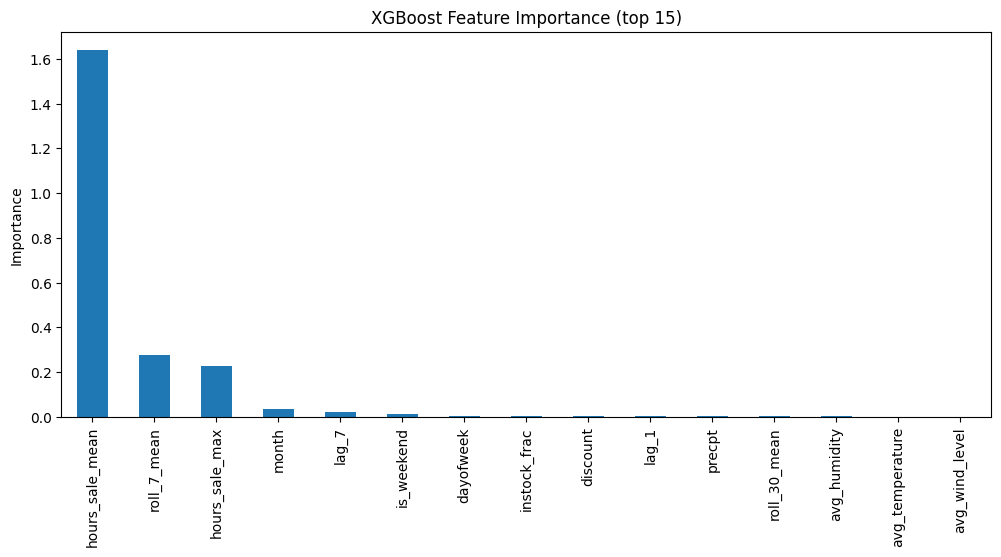

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if use_xgb:
    import xgboost as xgb
    score = xgb_model.get_score(importance_type="gain") or xgb_model.get_score(importance_type="weight")
    # handle both 'f0'.. and named features
    if all(k.startswith("f") and k[1:].isdigit() for k in score.keys()):
        fmap = {f"f{i}": feat for i, feat in enumerate(FEATURES)}
        imp = pd.Series({fmap[k]: v for k, v in score.items() if k in fmap})
    else:
        imp = pd.Series(score)
    imp = imp.reindex(FEATURES).fillna(0.0).sort_values(ascending=False)
else:
    base_imp = getattr(hgb, "feature_importances_", None)
    if base_imp is not None and np.nanmax(base_imp) > 0:
        imp = pd.Series(base_imp, index=FEATURES).sort_values(ascending=False)
    else:
        # permutation importance fallback if impurity importances are all zeros
        from sklearn.inspection import permutation_importance
        r = permutation_importance(hgb, X_valid, y_valid, n_repeats=5, random_state=42, n_jobs=-1)
        imp = pd.Series(r.importances_mean, index=FEATURES).sort_values(ascending=False)

ax = imp.head(15).plot(kind="bar", figsize=(12,5), title=f"{'XGBoost' if use_xgb else 'HistGB'} Feature Importance (top 15)")
ax.set_ylabel("Importance")
plt.show()

Cell 10 — Save model artifact

In [61]:
import joblib, json, datetime, pathlib

pathlib.Path("models").mkdir(exist_ok=True)
meta = {
    "created_at": datetime.datetime.utcnow().isoformat() + "Z",
    "features": FEATURES,
    "cutoff_date": str(cutoff_date.date()),
    "model_type": "xgboost" if use_xgb else "hist_gradient_boosting"
}

if use_xgb:
    xgb_path = "models/xgb_baseline.json"
    xgb_model.save_model(xgb_path)
    json.dump(meta, open("models/xgb_meta.json","w"))
    print("Saved:", xgb_path, "and models/xgb_meta.json")
else:
    joblib.dump(hgb, "models/histgb_baseline.pkl")
    json.dump(meta, open("models/histgb_meta.json","w"))
    print("Saved: models/histgb_baseline.pkl and models/histgb_meta.json")

Saved: models/xgb_baseline.json and models/xgb_meta.json


Prophet block

Cell P0 — Import Prophet

In [62]:
try:
    from prophet import Prophet
except Exception as e:
    print("Prophet not installed. Run:\n  source .venv/bin/activate && pip install prophet")
    raise e

Cell P1 — Build daily aggregates with regressors

In [63]:
base_cols = ["dt","sale_amount","discount","holiday_flag","activity_flag",
             "precpt","avg_temperature","avg_humidity","avg_wind_level"]

work = df[base_cols].copy()  # daily Prophet on totals + mean regressors
daily_agg = (
    work
    .groupby(pd.Grouper(key="dt", freq="D"))
    .agg({
        "sale_amount": "sum",
        "discount": "mean",
        "holiday_flag": "mean",
        "activity_flag": "mean",
        "precpt": "mean",
        "avg_temperature": "mean",
        "avg_humidity": "mean",
        "avg_wind_level": "mean",
    })
    .reset_index()
)

prophet_df = daily_agg.rename(columns={"dt":"ds", "sale_amount":"y"}).sort_values("ds").reset_index(drop=True)
prophet_df.head()

,ds,y,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
0,2024-03-28,1623.780,0.936617,0.0,0.330840,2.504104,16.721958,74.288619,1.760506
1,2024-03-29,1552.430,0.936769,0.0,0.298222,3.482089,16.297629,76.756922,1.654523
2,2024-03-30,2099.570,0.932673,1.0,0.327442,2.124929,17.010274,75.536312,1.780851
3,2024-03-31,2296.700,0.928729,1.0,0.332434,2.010730,17.314444,77.063194,1.742209
4,2024-04-01,1587.539,0.937635,0.0,0.300980,3.428167,16.742450,77.204676,1.566440


Cell P2 — Split for Prophet (last 30 days)

In [64]:
cutoff_date_p = prophet_df["ds"].max() - pd.Timedelta(days=30)
train_p = prophet_df[prophet_df["ds"] < cutoff_date_p].copy()
valid_p = prophet_df[prophet_df["ds"] >= cutoff_date_p].copy()

print("Prophet Train:", train_p["ds"].min().date(), "→", train_p["ds"].max().date(), "| rows:", len(train_p))
print("Prophet Valid:", valid_p["ds"].min().date(), "→", valid_p["ds"].max().date(), "| rows:", len(valid_p))

Prophet Train: 2024-03-28 → 2024-05-25 | rows: 59
Prophet Valid: 2024-05-26 → 2024-06-25 | rows: 31


Cell P3 — Fit Prophet with regressors

In [65]:
regressors = ["discount","holiday_flag","activity_flag",
              "precpt","avg_temperature","avg_humidity","avg_wind_level"]

m = Prophet(
    seasonality_mode="additive",
    weekly_seasonality=True,
    yearly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.5,
)

for r in regressors:
    m.add_regressor(r)

m.fit(train_p[["ds","y"] + regressors])

18:18:59 - cmdstanpy - INFO - Chain [1] start processing
18:18:59 - cmdstanpy - INFO - Chain [1] done processing


Cell P4 — Prophet predict (validation)

In [66]:
future_valid = valid_p[["ds"] + regressors].copy()
fcst_valid = m.predict(future_valid)

y_true_p = valid_p["y"].values
y_pred   = fcst_valid["yhat"].values

print(f"Prophet → RMSE: {rmse(y_true_p, y_pred):.3f}, MAPE: {mape_safe(y_true_p, y_pred):.2%}, SMAPE: {smape(y_true_p, y_pred):.2f}%")

Prophet → RMSE: 288.084, MAPE: 10.33%, SMAPE: 9.83%


Cell E — Unified comparison (daily aggregate for ALL models)

In [67]:
# ===== Unified Comparison on DAILY AGG level =====
import numpy as np, pandas as pd, pathlib

# safe metrics already defined: rmse, mape_safe, smape

def eval_daily_from_rows(y_true, y_pred, dates):
    df_true = pd.DataFrame({"dt": pd.to_datetime(dates), "y": np.asarray(y_true, dtype=float)})
    df_pred = pd.DataFrame({"dt": pd.to_datetime(dates), "yhat": np.asarray(y_pred, dtype=float)})
    daily_true = df_true.groupby("dt")["y"].sum()
    daily_pred = df_pred.groupby("dt")["yhat"].sum()
    daily_true, daily_pred = daily_true.align(daily_pred, join="inner")
    return daily_true.values, daily_pred.values

rows = []

# Baselines (daily)
daily_all = df.groupby("dt")["sale_amount"].sum().sort_index()
na_true, na_pred     = daily_all[1:].values,  daily_all.shift(1)[1:].values
ma7_true, ma7_pred   = daily_all[7:].values,  daily_all.rolling(7).mean().shift(1)[7:].values
ma30_true, ma30_pred = daily_all[30:].values, daily_all.rolling(30).mean().shift(1)[30:].values

rows += [
    {"Model":"Naive", "RMSE": rmse(na_true, na_pred), "MAPE": mape_safe(na_true, na_pred), "SMAPE": smape(na_true, na_pred)},
    {"Model":"MA7",   "RMSE": rmse(ma7_true, ma7_pred), "MAPE": mape_safe(ma7_true, ma7_pred), "SMAPE": smape(ma7_true, ma7_pred)},
    {"Model":"MA30",  "RMSE": rmse(ma30_true, ma30_pred), "MAPE": mape_safe(ma30_true, ma30_pred), "SMAPE": smape(ma30_true, ma30_pred)},
]

# HistGB (row -> daily)
hg_true, hg_pred = eval_daily_from_rows(y_valid, preds_hgb, valid["dt"])
rows.append({"Model":"HistGB", "RMSE": rmse(hg_true, hg_pred), "MAPE": mape_safe(hg_true, hg_pred), "SMAPE": smape(hg_true, hg_pred)})

# XGBoost (row -> daily) if present
if "use_xgb" in globals() and use_xgb and "preds_xgb" in globals():
    xgb_true, xgb_pred = eval_daily_from_rows(y_valid, preds_xgb, valid["dt"])
    rows.append({"Model":"XGBoost", "RMSE": rmse(xgb_true, xgb_pred), "MAPE": mape_safe(xgb_true, xgb_pred), "SMAPE": smape(xgb_true, xgb_pred)})

# Prophet (already daily)
prop_true, prop_pred = y_true_p, y_pred
rows.append({"Model":"Prophet", "RMSE": rmse(prop_true, prop_pred), "MAPE": mape_safe(prop_true, prop_pred), "SMAPE": smape(prop_true, prop_pred)})

df_results = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
display(df_results.style.format({"RMSE":"{:.3f}","MAPE":"{:.2%}","SMAPE":"{:.2f}%"}))

pathlib.Path("reports").mkdir(exist_ok=True)
df_results.to_csv("reports/model_comparison.csv", index=False)
print("Saved: reports/model_comparison.csv")

,Model,RMSE,MAPE,SMAPE
0,XGBoost,10.425,3.64%,3.78%
1,HistGB,21.923,14.64%,13.43%
2,Prophet,288.084,10.33%,9.83%
3,MA7,347.451,11.92%,12.17%
4,MA30,376.093,10.99%,11.60%
5,Naive,404.081,14.17%,13.87%


Saved: reports/model_comparison.csv


In [68]:
import pandas as pd, pathlib

# daily actuals from your sample
daily_hist = (
    df.groupby("dt")["sale_amount"]
      .sum()
      .reset_index()
      .rename(columns={"sale_amount":"actual"})
      .sort_values("dt")
)

pathlib.Path("reports").mkdir(exist_ok=True)
daily_hist.to_csv("reports/forecast_daily.csv", index=False)
print("Wrote reports/forecast_daily.csv", daily_hist.shape)

Wrote reports/forecast_daily.csv (90, 2)


In [69]:
import pandas as pd

hist = pd.read_csv("reports/forecast_daily.csv", parse_dates=["dt"])
fut  = pd.read_csv("reports/forecast_next_14d.csv", parse_dates=["dt"])

hist["set"] = "History"
hist["pred"] = pd.NA

fut = fut.rename(columns={"pred":"pred"})
fut["actual"] = pd.NA
fut["set"] = "Forecast"

combo = pd.concat([
    hist[["dt","actual","pred","set"]],
    fut[["dt","actual","pred","set"]]
], ignore_index=True).sort_values("dt")

combo.to_csv("reports/history_forecast_combo.csv", index=False)
print("Wrote reports/history_forecast_combo.csv", combo.shape)

Wrote reports/history_forecast_combo.csv (104, 4)


/var/folders/qx/xf4fpd4d70b71td0fcx6ks3r0000gn/T/ipykernel_1601/849955285.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combo = pd.concat([
